# Market Prediction

Elias Eskelinen, Vili Niemelä, Matti Aalto and Jarkko Komulainen

---

## Data onboarding

Initialize libraries

In [10]:
import os
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt

figs_dir = "./figures"
figs_dir = figs_dir if os.path.isdir(figs_dir) else ""

Fetch the data from the kaggle API (saved as a local file)

In [11]:
# Fetch the latest version of the dataset from kaggle
# Requires authentication

data_dir = kagglehub.competition_download('hull-tactical-market-prediction')
data_path = os.path.join(data_dir, "train.csv")

Load the data from the local file

In [12]:
data = pd.read_csv(data_path)
print(data.shape)
print(data.head())

(9021, 98)
   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]


In [13]:
# Skipping the missing values in the beginning of the time series and starting the data from day 1006, row 1008
data_resampled = data.iloc[1008:].reset_index(drop=True)
data_resampled = data_resampled.drop(columns=['risk_free_rate','market_forward_excess_returns'])
print(data_resampled.shape)

(8013, 96)


In [14]:
# Finding what data is missing the most entries
missing_counts = data_resampled.isnull().sum().sort_values(ascending=False)
print("Variables with missing values:", (missing_counts > 0).sum())

# Removing the variables from the dataset that have missing values
data_cleaned = data_resampled.loc[:, data_resampled.isnull().sum() == 0]
print(data_cleaned.shape)

Variables with missing values: 22
(8013, 74)


### PCA

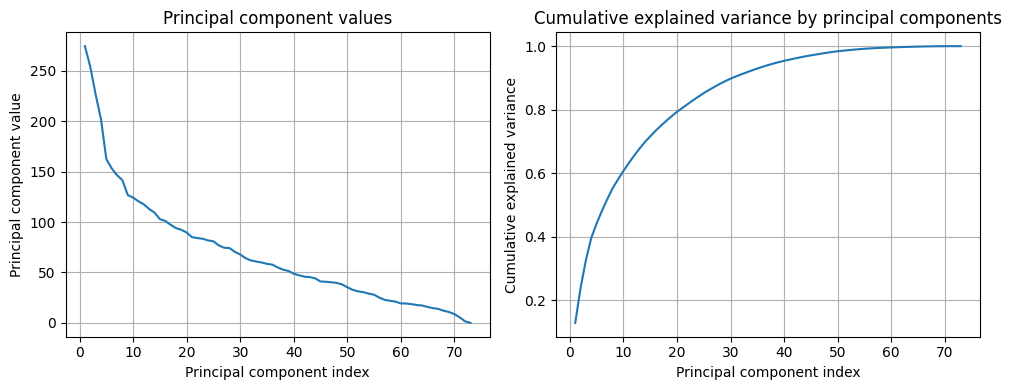

In [15]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

# Split data to X and y
predicted = "forward_returns"
features = [f for f in data_cleaned.columns if f != predicted]
X, y = data_cleaned[features], data_cleaned[predicted]

# Apply PCA to scaled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=X_scaled.shape[-1])
with warnings.catch_warnings(action="ignore"):
    X_pca = pca.fit_transform(X_scaled)

# Plot principal component values and cumulative explained variance as subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Principal component values
axs[0].plot(np.arange(1, len(pca.components_) + 1), pca.singular_values_)
axs[0].set_title("Principal component values")
axs[0].set_xlabel("Principal component index")
axs[0].set_ylabel("Principal component value")
axs[0].grid()

# Cumulative explained variance
axs[1].plot(np.arange(1, len(pca.components_)  + 1), pca.explained_variance_ratio_.cumsum())
axs[1].set_title("Cumulative explained variance by principal components")
axs[1].set_xlabel("Principal component index")
axs[1].set_ylabel("Cumulative explained variance")
axs[1].grid()

plt.tight_layout()
if figs_dir: plt.savefig(os.path.join(figs_dir, "principal_componets.png"))
plt.show()

### Kernel-PCA

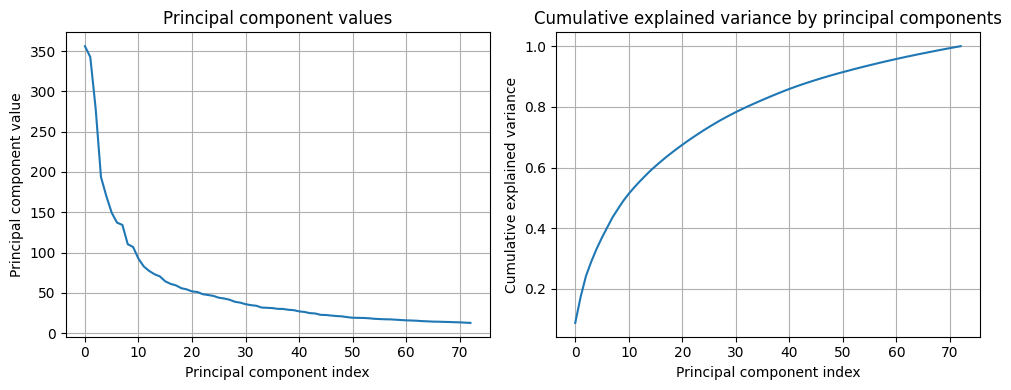

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA
#X, _ = load_digits(return_X_y=True)
#transformer = KernelPCA(n_components=7, kernel='linear')
#X_transformed = transformer.fit_transform(X)
#X_transformed.shape

# Apply kernel PCA to scaled data
kernel = 'rbf'
kpca = KernelPCA(n_components=X_scaled.shape[-1], kernel=kernel)
with warnings.catch_warnings(action="ignore"):
    X_kpca = kpca.fit_transform(X_scaled)

# Plot principal component values and cumulative explained variance as subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Principal component values
axs[0].plot(kpca.eigenvalues_)
axs[0].set_title("Principal component values")
axs[0].set_xlabel("Principal component index")
axs[0].set_ylabel("Principal component value")
axs[0].grid()

# Cumulative explained variance
axs[1].plot((kpca.eigenvalues_ / np.sum(kpca.eigenvalues_)).cumsum())
axs[1].set_title("Cumulative explained variance by principal components")
axs[1].set_xlabel("Principal component index")
axs[1].set_ylabel("Cumulative explained variance")
axs[1].grid()

plt.tight_layout()
if figs_dir: plt.savefig(os.path.join(figs_dir, "kernel_principal_components.png"))
plt.show()

## Transformer model


Sequence dataset: (7961, 51, 73) (7961,)
Epoch 1  Loss: 1.64315
Epoch 2  Loss: 1.43643
Epoch 3  Loss: 1.38854
Epoch 4  Loss: 1.36764
Epoch 5  Loss: 1.33741
Epoch 6  Loss: 1.32177
Epoch 7  Loss: 1.31459
Epoch 8  Loss: 1.29835
Epoch 9  Loss: 1.30580
Epoch 10  Loss: 1.28590


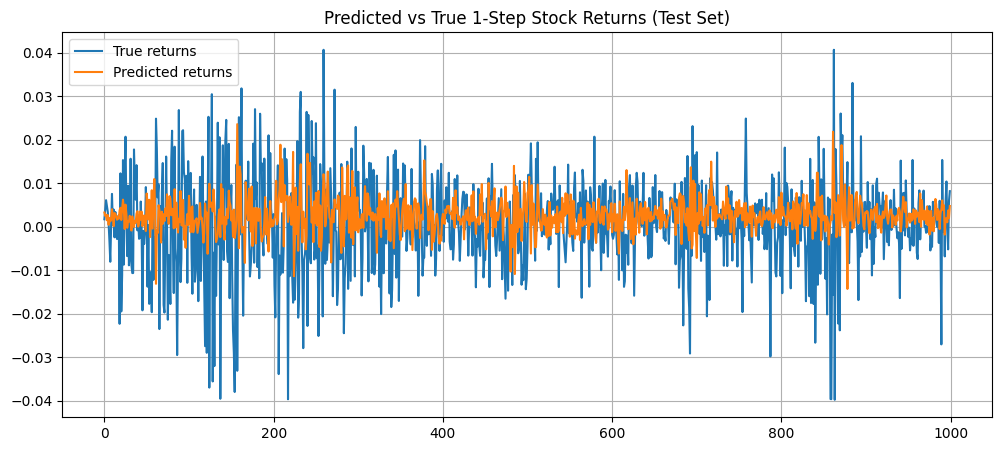

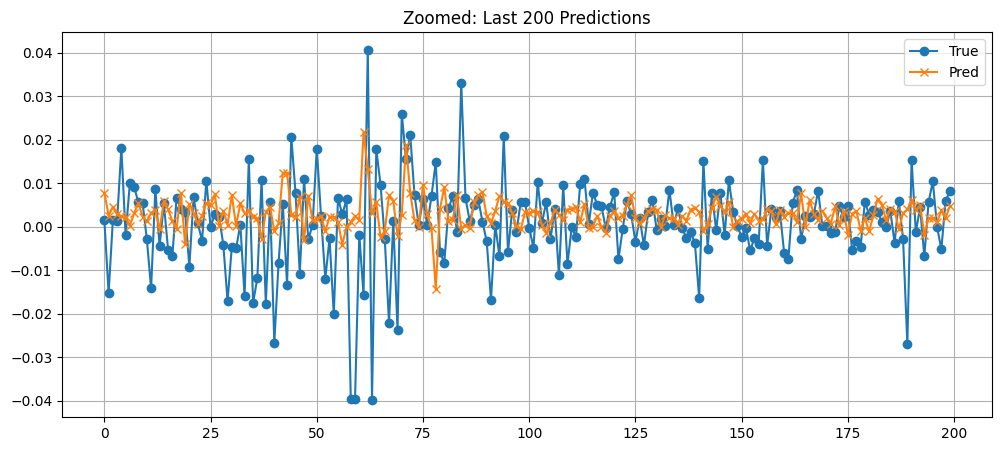

In [27]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


seq_length = 50  # number of past steps

def create_sequences(X, y, context_length, prediction_length, lags):
    max_lag = max(lags)
    required = context_length + prediction_length + max_lag

    Xs, ys = [], []

    for i in range(len(y) - required):
        past_window   = X[i : i + context_length + max_lag]  # e.g., 31 or 32 steps
        target_value  = y[i + context_length + max_lag]      # prediction point
        Xs.append(past_window)
        ys.append(target_value)

    return np.array(Xs), np.array(ys)

# Scale features (HF transformer strongly prefers standardized inputs)
# Convert raw inputs to numpy
X_np = np.asarray(X)
y_np = np.asarray(y).reshape(-1, 1)

# Scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_np)
y_scaled = scaler_y.fit_transform(y_np).flatten()

context_length = seq_length
prediction_length = 1
lags = [1]

X_seq, y_seq = create_sequences(X_scaled, y_scaled, context_length, prediction_length, lags)

print("Sequence dataset:", X_seq.shape, y_seq.shape)


test_size = 1000
train_size = len(X_seq) - test_size

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_test  = X_seq[train_size:]
y_test  = y_seq[train_size:]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

num_features = X_train.shape[-1]  # raw feature count

config = TimeSeriesTransformerConfig(
    prediction_length=1,
    context_length=seq_length,
    lags_sequence=[1],   # REQUIRED and MUST match your available past length
    d_model=128,
    encoder_layers=2,
    decoder_layers=2,
    num_time_features=num_features,
    num_static_real_features=0,
    num_static_categorical_features=0,
    num_parallel_samples=50,
)

model = TimeSeriesTransformerForPrediction(config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for bx, by in train_loader:
        bx = bx.to(device)      # [B, 30, F]
        by = by.to(device)      # [B]

        # HF formatting
        past_values = bx[:, :, 0]                       # choose feature 0 as target driver
        past_feat_dynamic_real = bx                     # all features as covariates
        past_observed_mask = torch.ones_like(past_values)

        future_values = by.unsqueeze(-1)
        future_feat_dynamic_real = torch.zeros(
            bx.size(0), config.prediction_length, num_features
        ).to(device)

        output = model(
            past_values=past_values,
            past_time_features=past_feat_dynamic_real,
            past_observed_mask=past_observed_mask,
            future_values=future_values,
            future_time_features=future_feat_dynamic_real
        )

        loss = output.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}  Loss: {total_loss/len(train_loader):.5f}")


model.eval()
preds = []

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    for i in range(len(X_test_t)):
        tx = X_test_t[i].unsqueeze(0)  # [1, 30, F]

        past_values = tx[:, :, 0]
        past_feat_dynamic_real = tx
        past_observed_mask = torch.ones_like(past_values)

        future_feat_dynamic_real = torch.zeros(
            1, config.prediction_length, num_features
        ).to(device)

        out = model.generate(
            past_values=past_values,
            past_time_features=past_feat_dynamic_real,
            past_observed_mask=past_observed_mask,
            future_time_features=future_feat_dynamic_real
        )

        # Mean over parallel samples
        pred = out.sequences.mean().cpu().item()
        preds.append(pred)

preds = np.array(preds)

preds_raw = scaler_y.inverse_transform(preds.reshape(-1,1)).flatten()
y_test_raw = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()

plt.figure(figsize=(12,5))
plt.plot(y_test_raw, label="True returns")
plt.plot(preds_raw, label="Predicted returns")
plt.title("Predicted vs True 1-Step Stock Returns (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

zoom = 200
plt.figure(figsize=(12,5))
plt.plot(y_test_raw[-zoom:], label="True", marker="o")
plt.plot(preds_raw[-zoom:], label="Pred", marker="x")
plt.title(f"Zoomed: Last {zoom} Predictions")
plt.legend()
plt.grid(True)
plt.show()
